## Design a GNN for beamforming and beamforming with antenna selection

In [2]:
import torch
import torch.nn.functional as F
import torch_geometric
import gzip
import pickle
import numpy as np
from pathlib import Path
from tqdm import tqdm, trange
import torch.nn as nn

LEARNING_RATE = 0.001
NB_EPOCHS = 50
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMB_SIZE = 64

from models.setting import *

ANTENNA_NFEATS = 2
EDGE_NFEATS = 3
VAR_NFEATS = 1

NUM_TRAIN_H = 1000
N, M = 8,3
L = 5
FCN_FEATS_SIZE = 88

class FCNLowerBound(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
                    nn.Linear(FCN_FEATS_SIZE, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
            
#                     nn.Linear(512, 512),
#                     nn.BatchNorm1d(512),
#                     nn.ReLU(),
            
                    nn.Linear(512, 256),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                    )
        self.z_module = torch.nn.Sequential(
                    nn.Linear(256, 64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    
                    nn.Linear(64, N),
                    nn.Sigmoid()
                    )
        self.power_module = torch.nn.Sequential(
                    nn.Linear(256, 64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    
                    nn.Linear(64, 1),
                    nn.ReLU()
                    )
        
    def forward(self, inp):
        latent = self.main(inp)
        return self.z_module(latent), self.power_module(latent)

class GNNLowerBound(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # ANTENNA EMBEDDING
        self.antenna_embedding = torch.nn.Sequential(
            torch.nn.LayerNorm(ANTENNA_NFEATS),
            torch.nn.Linear(ANTENNA_NFEATS, EMB_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(EMB_SIZE, EMB_SIZE),
            torch.nn.ReLU(),
        )

        # EDGE EMBEDDING
        self.edge_embedding = torch.nn.Sequential(
            torch.nn.LayerNorm(EDGE_NFEATS),
            torch.nn.Linear(EDGE_NFEATS, EMB_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(EMB_SIZE, EMB_SIZE),
            torch.nn.ReLU(),
        )

        # USER EMBEDDING
        self.user_embedding = torch.nn.Sequential(
            torch.nn.LayerNorm(VAR_NFEATS),
            torch.nn.Linear(VAR_NFEATS, EMB_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(EMB_SIZE, EMB_SIZE),
            torch.nn.ReLU(),
        )

        self.conv_user_to_antenna = BipartiteGraphConvolution()
        self.conv_antenna_to_user = BipartiteGraphConvolution()
        self.conv_antenna_to_user_final = BipartiteGraphConvolution()
        
        self.output_integral_module = torch.nn.Sequential(
            torch.nn.Linear(EMB_SIZE, EMB_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(EMB_SIZE, 1, bias=False),
            torch.nn.Sigmoid(),
        )
        
        self.output_power_module = torch.nn.Sequential(
            torch.nn.Linear(EMB_SIZE, EMB_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(EMB_SIZE, 1, bias=False),
        )

    def forward(self, obs):
        return self.pass_nn(obs.antenna_features, obs.edge_index, obs.edge_attr, obs.variable_features)
    
    def pass_nn(self, antenna_features, edge_indices, edge_features, user_features):
        reversed_edge_indices = torch.stack([edge_indices[1], edge_indices[0]], dim=0)

        # First step: linear embedding layers to a common dimension (64)
        antenna_features = self.antenna_embedding(antenna_features)
        edge_features = self.edge_embedding(edge_features)
        user_features = self.user_embedding(user_features)
        
        # Two half convolutions
        user_features = self.conv_antenna_to_user(antenna_features, edge_indices, edge_features, user_features)
        antenna_features = self.conv_user_to_antenna(user_features, reversed_edge_indices, edge_features, antenna_features)
        
        final_user_features = self.conv_antenna_to_user(antenna_features, edge_indices, edge_features, user_features)

        # A final MLP on the antenna features
        output_integral_relaxed = self.output_integral_module(antenna_features).squeeze(-1)
        
        output_power = self.output_power_module(final_user_features)
        output_power = output_power.sum()
        return (output_integral_relaxed, output_power)

class BipartiteGraphConvolution(torch_geometric.nn.MessagePassing):
    """
    The bipartite graph convolution is already provided by pytorch geometric and we merely need 
    to provide the exact form of the messages being passed.
    """
    def __init__(self):
        super().__init__('add')
        
        self.feature_module_left = torch.nn.Sequential(
            torch.nn.Linear(EMB_SIZE, EMB_SIZE)
        )
        self.feature_module_edge = torch.nn.Sequential(
            torch.nn.Linear(EMB_SIZE, EMB_SIZE, bias=False)
        )
        self.feature_module_right = torch.nn.Sequential(
            torch.nn.Linear(EMB_SIZE, EMB_SIZE, bias=False)
        )
        self.feature_module_final = torch.nn.Sequential(
            torch.nn.LayerNorm(EMB_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(EMB_SIZE, EMB_SIZE)
        )
        
        self.post_conv_module = torch.nn.Sequential(
            torch.nn.LayerNorm(EMB_SIZE)
        )

        # output_layers
        self.output_module = torch.nn.Sequential(
            torch.nn.Linear(2*EMB_SIZE, EMB_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(EMB_SIZE, EMB_SIZE),
        )

        
    def forward(self, left_features, edge_indices, edge_features, right_features):
        """
        This method sends the messages, computed in the message method.
        """
        output = self.propagate(edge_indices, size=(left_features.shape[0], right_features.shape[0]), 
                                node_features=(left_features, right_features), edge_features=edge_features)
        return self.output_module(torch.cat([self.post_conv_module(output), right_features], dim=-1))

    def message(self, node_features_i, node_features_j, edge_features):
        output = self.feature_module_final(self.feature_module_left(node_features_i) 
                                           + self.feature_module_edge(edge_features) 
                                           + self.feature_module_right(node_features_j))
        return output



class LowerBoundObservation(object):
    def __init__(self, H_complex, z_sol, z_mask):
        self.antenna_features  = None # np.zeros(N, 3) # three features for each antenna
        self.variable_features = None # np.zeros(M, 15)
        
        self.candidates        = [0] # np.arange(M)
        
        N, M = H_complex.shape
        
        # edge indices
        self.edge_index = np.stack((np.repeat(np.arange(N), M), np.tile(np.arange(M), N)))
        
        # edge features definition
        self.edge_features = np.zeros((M*N, EDGE_NFEATS))
        self.edge_features[:,0] = np.real(H_complex.reshape(-1))
        self.edge_features[:,1] = np.imag(H_complex.reshape(-1))
        self.edge_features[:,2] = np.abs(H_complex.reshape(-1))
        
        # antenna features definition
        self.antenna_features = np.zeros((N, ANTENNA_NFEATS))
        self.antenna_features[:,0] = z_sol
        self.antenna_features[:,1] = z_mask
        
        # user features definition
        self.variable_features = np.ones((M, VAR_NFEATS))
        
    def extract(self):
        return self
    

class LinearLowerBoundObservation(object):
    def __init__(self, H_complex, z_sol, z_mask):
        self.observation = np.concatenate((np.real(H_complex.reshape(-1)), 
                                            np.imag(H_complex.reshape(-1)),
                                            np.abs(H_complex.reshape(-1))))
        self.observation = np.concatenate((self.observation, 
                                         z_sol.reshape(-1),
                                         z_mask.reshape(-1)))
        
    def extract(self):
        return self
    

class LinearLowerBoundDataset(torch.utils.data.Dataset):
    def __init__(self, data_filepath):
        super().__init__()
        with open(data_filepath, 'rb') as handle:
            self.data = pickle.load(handle)

    def __len__(self):
        return len(self.data['out'])

    def __getitem__(self, index):
        sample_observation, np_target = self.data['in'][index], self.data['out'][index]
        
        target = []
        for i in range(len(np_target)):
            target.append(torch.tensor(np_target[i]))
        
        return sample_observation.observation, target
        
    
class GraphLowerBoundDataset(torch_geometric.data.Dataset):
    """
    This class encodes a collection of graphs, as well as a method to load such graphs from the disk.
    It can be used in turn by the data loaders provided by pytorch geometric.
    """
    def __init__(self, data_filepath):
        super().__init__(root=None, transform=None, pre_transform=None)
        with open(data_filepath, 'rb') as handle:
            self.data = pickle.load(handle)

    def len(self):
        return len(self.data['out'])

    def get(self, index):
        """
        This method loads a node bipartite graph observation as saved on the disk during data collection.
        """
        
        sample_observation, np_target = self.data['in'][index], self.data['out'][index]
        
        target = []
        for i in range(len(np_target)):
            target.append(torch.tensor(np_target[i]))
            
        # not important
        candidates = torch.LongTensor(np.array([1,2,3], dtype=np.int32))
        candidate_choice = 1 
        sample_observation.variable_features = np.ones((M, VAR_NFEATS))
#         print(target[2])
        if target[2] < 0:
            target[2] = torch.FloatTensor(np.array(0.0))
        if target[2] > 1:
            target[2] = torch.FloatTensor(np.array(1.0))
        graph = BipartiteNodeData(sample_observation.antenna_features, sample_observation.edge_index, 
                                  sample_observation.edge_features, sample_observation.variable_features,
                                  candidates, candidate_choice)
        
        # We must tell pytorch geometric how many nodes there are, for indexing purposes
        graph.num_nodes = sample_observation.antenna_features.shape[0] + sample_observation.variable_features.shape[0]
        
        return graph, target
    

## GNN Relaxed antenna Beamforming Training

In [3]:
import torch_geometric
from models.gnn_dataset import *

### Train the GNN policy using supervised learning (L2-norm loss)

# Instantiate model and training parameters
num_epochs = 100
batch_size = 64
lr = 0.0001
wt_power = 1
Device = 'cuda'

model = GNNLowerBound()
model = model.to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

data_filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/trainset1_pruned.pkl'
train_dataset = GraphLowerBoundDataset(data_filepath)
train_dataloader = torch_geometric.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/validset1_pruned.pkl'
valid_dataset =  GraphLowerBoundDataset(valid_filepath)
valid_dataloader = torch_geometric.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

loss_func = torch.nn.L1Loss()

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_sum = 0
    for batch in tqdm(train_dataloader):        
        graph, (z_target, _, power_target) = batch
        graph = graph.to(Device)
        z_target = z_target.to(Device).to(torch.float32)
        power_target = power_target.to(Device).to(torch.float32)
        
        z_out, power_out = model(graph)
#         print(loss_func(z_out, z_target.flatten()), wt_power*loss_func(power_out, power_target))
        train_loss = loss_func(z_out, z_target.flatten()) + wt_power*loss_func(power_out, power_target)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_loss_sum += train_loss.item()
    train_losses.append(train_loss_sum/(len(train_dataset)/batch_size))
#         print(next(model.parameters()))
        
    # Validation
    model.eval()
    valid_loss_sum = 0
    for batch in tqdm(valid_dataloader):
        graph, (z_target, _, power_target) = batch
        graph = graph.to(Device)
        z_target = z_target.to(Device).to(torch.float32)
        power_target = power_target.to(Device).to(torch.float32)
        
        z_out, power_out = model(graph)
        valid_loss = loss_func(z_out, z_target.flatten()) + wt_power*loss_func(power_out, power_target) 
        valid_loss_sum += valid_loss.item()
    valid_losses.append(valid_loss_sum/(len(valid_dataset)/batch_size))
        
    print('training loss: {}, valid loss: {}'.format(train_loss, valid_loss) )
        

# Using the supervised model do antenna selection with branch and bound (as_bb)


/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/131 [00:00<?, ?it/s]/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 127/131 [00:03<00:00, 35.43it/s]/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=sel

training loss: 0.46768057346343994, valid loss: 0.516101598739624


100%|██████████| 16/16 [00:00<00:00, 39.34it/s]


training loss: 0.4719253480434418, valid loss: 0.5957508683204651


100%|██████████| 16/16 [00:00<00:00, 59.31it/s]


training loss: 0.4462070167064667, valid loss: 0.46035444736480713


100%|██████████| 16/16 [00:00<00:00, 55.48it/s]


training loss: 0.48023152351379395, valid loss: 0.47765105962753296


100%|██████████| 16/16 [00:00<00:00, 59.21it/s]


training loss: 0.35952210426330566, valid loss: 0.4718726873397827


100%|██████████| 16/16 [00:00<00:00, 55.90it/s]


training loss: 0.3700847327709198, valid loss: 0.3989936113357544


100%|██████████| 16/16 [00:00<00:00, 59.54it/s]


training loss: 0.33503299951553345, valid loss: 0.381969690322876


100%|██████████| 16/16 [00:00<00:00, 60.84it/s]


training loss: 0.28115931153297424, valid loss: 0.3679596185684204


100%|██████████| 16/16 [00:00<00:00, 62.47it/s]


training loss: 0.4388917088508606, valid loss: 0.44196709990501404


100%|██████████| 16/16 [00:00<00:00, 64.11it/s]


training loss: 0.3091740906238556, valid loss: 0.34988826513290405


100%|██████████| 16/16 [00:00<00:00, 62.96it/s]


training loss: 0.36405619978904724, valid loss: 0.37657418847084045


100%|██████████| 16/16 [00:00<00:00, 50.50it/s]


training loss: 0.40158557891845703, valid loss: 0.40566450357437134


100%|██████████| 16/16 [00:00<00:00, 57.89it/s]


training loss: 0.30892086029052734, valid loss: 0.36241692304611206


100%|██████████| 16/16 [00:00<00:00, 56.78it/s]


training loss: 0.3142533004283905, valid loss: 0.3748288154602051


100%|██████████| 16/16 [00:00<00:00, 59.69it/s]


training loss: 0.33063623309135437, valid loss: 0.35942667722702026


100%|██████████| 16/16 [00:00<00:00, 60.16it/s]


training loss: 0.3051203787326813, valid loss: 0.40703001618385315


100%|██████████| 16/16 [00:00<00:00, 41.39it/s]


training loss: 0.27392786741256714, valid loss: 0.43701863288879395


100%|██████████| 16/16 [00:00<00:00, 57.68it/s]


training loss: 0.2951206564903259, valid loss: 0.43457189202308655


100%|██████████| 16/16 [00:00<00:00, 56.79it/s]


training loss: 0.34776854515075684, valid loss: 0.3643620014190674


100%|██████████| 16/16 [00:00<00:00, 55.46it/s]


training loss: 0.345192551612854, valid loss: 0.3283292055130005


100%|██████████| 16/16 [00:00<00:00, 59.50it/s]


training loss: 0.34427410364151, valid loss: 0.39938682317733765


100%|██████████| 16/16 [00:00<00:00, 55.84it/s]


training loss: 0.255595862865448, valid loss: 0.35498422384262085


100%|██████████| 16/16 [00:00<00:00, 56.87it/s]


training loss: 0.33751314878463745, valid loss: 0.40878725051879883


100%|██████████| 16/16 [00:00<00:00, 55.89it/s]


training loss: 0.3053927421569824, valid loss: 0.3582421839237213


100%|██████████| 16/16 [00:00<00:00, 59.08it/s]


training loss: 0.288928747177124, valid loss: 0.40208637714385986


100%|██████████| 16/16 [00:00<00:00, 56.26it/s]


training loss: 0.3050110340118408, valid loss: 0.3775705099105835


100%|██████████| 16/16 [00:00<00:00, 61.92it/s]


training loss: 0.31519025564193726, valid loss: 0.34794652462005615


100%|██████████| 16/16 [00:00<00:00, 53.38it/s]


training loss: 0.3189358711242676, valid loss: 0.30903729796409607


100%|██████████| 16/16 [00:00<00:00, 63.24it/s]


training loss: 0.27615416049957275, valid loss: 0.3153423070907593


100%|██████████| 16/16 [00:00<00:00, 60.16it/s]


training loss: 0.3023919463157654, valid loss: 0.2694651484489441


100%|██████████| 16/16 [00:00<00:00, 60.08it/s]


training loss: 0.3538574278354645, valid loss: 0.4297703802585602


100%|██████████| 16/16 [00:00<00:00, 71.02it/s]


training loss: 0.29183074831962585, valid loss: 0.380098819732666


100%|██████████| 16/16 [00:00<00:00, 62.18it/s]


training loss: 0.301535964012146, valid loss: 0.34500235319137573


100%|██████████| 16/16 [00:00<00:00, 53.12it/s]


training loss: 0.30894601345062256, valid loss: 0.37638944387435913


100%|██████████| 16/16 [00:00<00:00, 55.98it/s]


training loss: 0.3655066192150116, valid loss: 0.36209362745285034


100%|██████████| 16/16 [00:00<00:00, 47.21it/s]


training loss: 0.31906646490097046, valid loss: 0.3998977243900299


100%|██████████| 16/16 [00:00<00:00, 56.31it/s]


training loss: 0.27796217799186707, valid loss: 0.36761757731437683


100%|██████████| 16/16 [00:00<00:00, 48.16it/s]


training loss: 0.2966352105140686, valid loss: 0.332929790019989


100%|██████████| 16/16 [00:00<00:00, 57.71it/s]


training loss: 0.35089901089668274, valid loss: 0.3842630386352539


100%|██████████| 16/16 [00:00<00:00, 58.11it/s]


training loss: 0.32792532444000244, valid loss: 0.40205469727516174


100%|██████████| 16/16 [00:00<00:00, 62.23it/s]


training loss: 0.35304492712020874, valid loss: 0.3564513325691223


100%|██████████| 16/16 [00:00<00:00, 54.23it/s]


training loss: 0.37093669176101685, valid loss: 0.40458962321281433


100%|██████████| 16/16 [00:00<00:00, 57.96it/s]


training loss: 0.2897804379463196, valid loss: 0.3721744418144226


100%|██████████| 16/16 [00:00<00:00, 59.53it/s]


training loss: 0.30437105894088745, valid loss: 0.35795626044273376


100%|██████████| 16/16 [00:00<00:00, 67.73it/s]


training loss: 0.27421119809150696, valid loss: 0.37516844272613525


100%|██████████| 16/16 [00:00<00:00, 71.88it/s]


training loss: 0.2957090735435486, valid loss: 0.3496364951133728


100%|██████████| 16/16 [00:00<00:00, 69.43it/s]


training loss: 0.2807910144329071, valid loss: 0.39877116680145264


100%|██████████| 16/16 [00:00<00:00, 63.33it/s]


training loss: 0.31776192784309387, valid loss: 0.3810705840587616


100%|██████████| 16/16 [00:00<00:00, 53.51it/s]


training loss: 0.30909693241119385, valid loss: 0.3386942446231842


100%|██████████| 16/16 [00:00<00:00, 56.18it/s]


training loss: 0.26978811621665955, valid loss: 0.4106333255767822


100%|██████████| 16/16 [00:00<00:00, 55.09it/s]


training loss: 0.3508056402206421, valid loss: 0.3934006094932556


100%|██████████| 16/16 [00:00<00:00, 49.69it/s]


training loss: 0.26659074425697327, valid loss: 0.31355953216552734


100%|██████████| 16/16 [00:00<00:00, 50.76it/s]


training loss: 0.2745888829231262, valid loss: 0.3166998326778412


100%|██████████| 16/16 [00:00<00:00, 54.52it/s]


training loss: 0.3109041452407837, valid loss: 0.3962063789367676


100%|██████████| 16/16 [00:00<00:00, 53.86it/s]


training loss: 0.304914653301239, valid loss: 0.31430840492248535


100%|██████████| 16/16 [00:00<00:00, 52.17it/s]


training loss: 0.3119797110557556, valid loss: 0.3594144880771637


100%|██████████| 16/16 [00:00<00:00, 60.35it/s]


training loss: 0.30758872628211975, valid loss: 0.338541179895401


100%|██████████| 16/16 [00:00<00:00, 54.77it/s]


training loss: 0.30143216252326965, valid loss: 0.3563607931137085


100%|██████████| 16/16 [00:00<00:00, 49.72it/s]


training loss: 0.3354279398918152, valid loss: 0.40420666337013245


100%|██████████| 16/16 [00:00<00:00, 62.53it/s]


training loss: 0.31096023321151733, valid loss: 0.3403853178024292


100%|██████████| 16/16 [00:00<00:00, 64.23it/s]


training loss: 0.29343631863594055, valid loss: 0.35941725969314575


100%|██████████| 16/16 [00:00<00:00, 68.33it/s]


training loss: 0.3182772099971771, valid loss: 0.3439257740974426


100%|██████████| 16/16 [00:00<00:00, 59.58it/s]


training loss: 0.3521653413772583, valid loss: 0.3356936573982239


100%|██████████| 16/16 [00:00<00:00, 61.04it/s]


training loss: 0.31794196367263794, valid loss: 0.3987475633621216


100%|██████████| 16/16 [00:00<00:00, 59.61it/s]


training loss: 0.30010390281677246, valid loss: 0.36217063665390015


100%|██████████| 16/16 [00:00<00:00, 53.81it/s]


training loss: 0.2679130733013153, valid loss: 0.3055421710014343


100%|██████████| 16/16 [00:00<00:00, 54.78it/s]


training loss: 0.2885948121547699, valid loss: 0.34908562898635864


100%|██████████| 16/16 [00:00<00:00, 54.62it/s]


training loss: 0.2767467796802521, valid loss: 0.31977221369743347


100%|██████████| 16/16 [00:00<00:00, 57.41it/s]


training loss: 0.2996816039085388, valid loss: 0.3179095983505249


100%|██████████| 16/16 [00:00<00:00, 55.05it/s]


training loss: 0.34432679414749146, valid loss: 0.380767285823822


100%|██████████| 16/16 [00:00<00:00, 51.47it/s]


training loss: 0.275278776884079, valid loss: 0.39986929297447205


100%|██████████| 16/16 [00:00<00:00, 56.66it/s]


training loss: 0.285375714302063, valid loss: 0.3704702854156494


100%|██████████| 16/16 [00:00<00:00, 57.70it/s]


training loss: 0.3046683073043823, valid loss: 0.3648768961429596


100%|██████████| 16/16 [00:00<00:00, 51.64it/s]


training loss: 0.3022057116031647, valid loss: 0.33929622173309326


100%|██████████| 16/16 [00:00<00:00, 53.36it/s]


training loss: 0.33048805594444275, valid loss: 0.3746638894081116


100%|██████████| 16/16 [00:00<00:00, 51.89it/s]


training loss: 0.29886263608932495, valid loss: 0.2966708838939667


100%|██████████| 16/16 [00:00<00:00, 66.40it/s]


training loss: 0.2390182614326477, valid loss: 0.35082852840423584


100%|██████████| 16/16 [00:00<00:00, 50.32it/s]


training loss: 0.31662672758102417, valid loss: 0.4167730510234833


100%|██████████| 16/16 [00:00<00:00, 64.63it/s]


training loss: 0.3147980868816376, valid loss: 0.35410478711128235


100%|██████████| 16/16 [00:00<00:00, 65.28it/s]


training loss: 0.2659808397293091, valid loss: 0.3348965048789978


100%|██████████| 16/16 [00:00<00:00, 50.43it/s]


training loss: 0.3281403183937073, valid loss: 0.34352850914001465


100%|██████████| 16/16 [00:00<00:00, 46.36it/s]


training loss: 0.28543993830680847, valid loss: 0.3429262042045593


100%|██████████| 16/16 [00:00<00:00, 55.37it/s]


training loss: 0.2850934863090515, valid loss: 0.37559205293655396


100%|██████████| 16/16 [00:00<00:00, 55.34it/s]


training loss: 0.2883685231208801, valid loss: 0.35485124588012695


100%|██████████| 16/16 [00:00<00:00, 54.03it/s]


training loss: 0.3327752351760864, valid loss: 0.32663607597351074


100%|██████████| 16/16 [00:00<00:00, 58.08it/s]


training loss: 0.36730024218559265, valid loss: 0.3855200409889221


100%|██████████| 16/16 [00:00<00:00, 54.41it/s]


training loss: 0.3141593337059021, valid loss: 0.39355990290641785


100%|██████████| 16/16 [00:00<00:00, 50.21it/s]


training loss: 0.3352273106575012, valid loss: 0.4152200222015381


100%|██████████| 16/16 [00:00<00:00, 33.54it/s]


training loss: 0.2857319712638855, valid loss: 0.325951486825943


100%|██████████| 16/16 [00:00<00:00, 52.76it/s]


training loss: 0.32735711336135864, valid loss: 0.3281105160713196


100%|██████████| 16/16 [00:00<00:00, 53.89it/s]


training loss: 0.28879380226135254, valid loss: 0.3672609329223633


100%|██████████| 16/16 [00:00<00:00, 60.09it/s]


training loss: 0.34054604172706604, valid loss: 0.39036843180656433


100%|██████████| 16/16 [00:00<00:00, 60.54it/s]


training loss: 0.3202846646308899, valid loss: 0.31636595726013184


100%|██████████| 16/16 [00:00<00:00, 58.65it/s]


training loss: 0.3082285225391388, valid loss: 0.3487163186073303


100%|██████████| 16/16 [00:00<00:00, 61.79it/s]


training loss: 0.29907718300819397, valid loss: 0.33747726678848267


100%|██████████| 16/16 [00:00<00:00, 60.83it/s]


training loss: 0.28450217843055725, valid loss: 0.40423834323883057


100%|██████████| 16/16 [00:00<00:00, 61.24it/s]


training loss: 0.33732882142066956, valid loss: 0.41096457839012146


100%|██████████| 16/16 [00:00<00:00, 55.87it/s]


training loss: 0.26592129468917847, valid loss: 0.31281042098999023


100%|██████████| 16/16 [00:00<00:00, 57.02it/s]


training loss: 0.30652856826782227, valid loss: 0.4382251799106598


100%|██████████| 16/16 [00:00<00:00, 48.85it/s]

training loss: 0.32280561327934265, valid loss: 0.3482179641723633


In [11]:
len(train_losses)

13100

In [9]:
torch.save( model.to('cpu').eval().state_dict(),'trained_models/lower_bound_gnn.model')

In [7]:
model

GNNLowerBound(
  (antenna_embedding): Sequential(
    (0): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=2, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (edge_embedding): Sequential(
    (0): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=3, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (user_embedding): Sequential(
    (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=1, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (conv_user_to_antenna): BipartiteGraphConvolution(
    (feature_module_left): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (feature_module_edge): Sequential(
      (0): Linear(in_features=64, out_f

## FCN Relaxed antenna Beamforming Training

In [20]:
import torch_geometric
from models.gnn_dataset import *

### Train the GNN policy using supervised learning (L2-norm loss)

# Instantiate model and training parameters
num_epochs = 100
batch_sizes = [32, 64, 128]
lrs = [0.01, 0.001, 0.0001, 0.00001]
wt_power = 1
Device = 'cuda'

model = FCNLowerBound()
model = model.to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_func = torch.nn.L1Loss()

train_losses = []
valid_losses = []

result = {'lr': [], 'bs': [], 'error': []}

for lr in lrs:
    for batch_size in batch_sizes:
        
        data_filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/trainset1_linear_pruned.pkl'
        train_dataset = LinearLowerBoundDataset(data_filepath)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        valid_filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/validset1_linear_pruned.pkl'
        valid_dataset =  LinearLowerBoundDataset(valid_filepath)
        valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            # Training
            model.train()
            for batch in train_dataloader:        
                feats, (z_target, _, power_target) = batch
                feats = feats.to(Device).to(torch.float32)
                z_target = z_target.to(Device).to(torch.float32)
                power_target = power_target.to(Device).to(torch.float32)

                z_out, power_out = model(feats)
        #         print(loss_func(z_out, z_target.flatten()), wt_power*loss_func(power_out, power_target))
                train_loss = loss_func(z_out, z_target) + wt_power*loss_func(power_out, power_target)
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
                train_losses.append(train_loss.detach().item())
        #         print(next(model.parameters()))

            # Validation
            model.eval()
            for batch in valid_dataloader:
                feats, (z_target, _, power_target) = batch
                feats = feats.to(Device).to(torch.float32)
                z_target = z_target.to(Device).to(torch.float32)
                power_target = power_target.to(Device).to(torch.float32)

                z_out, power_out = model(feats)
                valid_loss = loss_func(z_out, z_target) + wt_power*loss_func(power_out, power_target) 
                valid_losses.append(valid_loss.detach().item())

            print('epoch: {}, lr: {}, bs: {}, btraining loss: {}, valid loss: {}'.format(epoch, lr, batch_size, train_loss, valid_loss) )
        
        result['lr'].append(lr)
        result['bs'].append(batch_size)
        result['error'].append((train_loss, valid_loss))
        
# Using the supervised model do antenna selection with branch and bound (as_bb)


epoch: 0, lr: 0.01, bs: 32, btraining loss: 0.42861735820770264, valid loss: 0.620774507522583
epoch: 1, lr: 0.01, bs: 32, btraining loss: 0.1980932503938675, valid loss: 0.16368108987808228
epoch: 2, lr: 0.01, bs: 32, btraining loss: 0.2511577606201172, valid loss: 0.1387057900428772
epoch: 3, lr: 0.01, bs: 32, btraining loss: 0.34826773405075073, valid loss: 0.1005231961607933
epoch: 4, lr: 0.01, bs: 32, btraining loss: 0.278256893157959, valid loss: 0.0837225466966629
epoch: 5, lr: 0.01, bs: 32, btraining loss: 0.2947612404823303, valid loss: 0.08160193264484406
epoch: 6, lr: 0.01, bs: 32, btraining loss: 0.15046468377113342, valid loss: 0.09768325090408325
epoch: 7, lr: 0.01, bs: 32, btraining loss: 0.1726491004228592, valid loss: 0.08520328998565674
epoch: 8, lr: 0.01, bs: 32, btraining loss: 0.20644529163837433, valid loss: 0.13015218079090118
epoch: 9, lr: 0.01, bs: 32, btraining loss: 0.21209506690502167, valid loss: 0.08680062741041183
epoch: 10, lr: 0.01, bs: 32, btraining lo

epoch: 85, lr: 0.01, bs: 32, btraining loss: 0.20617803931236267, valid loss: 0.04368310421705246
epoch: 86, lr: 0.01, bs: 32, btraining loss: 0.27887749671936035, valid loss: 0.1301981508731842
epoch: 87, lr: 0.01, bs: 32, btraining loss: 0.16623005270957947, valid loss: 0.09551891684532166
epoch: 88, lr: 0.01, bs: 32, btraining loss: 0.2498883157968521, valid loss: 0.07278881222009659
epoch: 89, lr: 0.01, bs: 32, btraining loss: 0.2552330493927002, valid loss: 0.08410249650478363
epoch: 90, lr: 0.01, bs: 32, btraining loss: 0.2655291259288788, valid loss: 0.4106316566467285
epoch: 91, lr: 0.01, bs: 32, btraining loss: 0.2497379034757614, valid loss: 0.08771899342536926
epoch: 92, lr: 0.01, bs: 32, btraining loss: 0.3539169728755951, valid loss: 0.16160091757774353
epoch: 93, lr: 0.01, bs: 32, btraining loss: 0.22796094417572021, valid loss: 0.44299566745758057
epoch: 94, lr: 0.01, bs: 32, btraining loss: 0.22112859785556793, valid loss: 0.24217849969863892
epoch: 95, lr: 0.01, bs: 32

epoch: 70, lr: 0.01, bs: 64, btraining loss: 0.1746852844953537, valid loss: 0.13959725201129913
epoch: 71, lr: 0.01, bs: 64, btraining loss: 0.1550050526857376, valid loss: 0.13410373032093048
epoch: 72, lr: 0.01, bs: 64, btraining loss: 0.23616857826709747, valid loss: 0.2957310378551483
epoch: 73, lr: 0.01, bs: 64, btraining loss: 0.15014448761940002, valid loss: 0.1456078439950943
epoch: 74, lr: 0.01, bs: 64, btraining loss: 0.3400086462497711, valid loss: 0.4472547173500061
epoch: 75, lr: 0.01, bs: 64, btraining loss: 0.18218840658664703, valid loss: 0.14871864020824432
epoch: 76, lr: 0.01, bs: 64, btraining loss: 0.1661524921655655, valid loss: 0.0913306400179863
epoch: 77, lr: 0.01, bs: 64, btraining loss: 0.17897862195968628, valid loss: 0.10661643743515015
epoch: 78, lr: 0.01, bs: 64, btraining loss: 0.16879519820213318, valid loss: 0.281566858291626
epoch: 79, lr: 0.01, bs: 64, btraining loss: 0.204035684466362, valid loss: 0.2604861259460449
epoch: 80, lr: 0.01, bs: 64, btra

/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([66])) that is different to the input size (torch.Size([66, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch: 0, lr: 0.01, bs: 128, btraining loss: 0.2462499439716339, valid loss: 0.15773998200893402
epoch: 1, lr: 0.01, bs: 128, btraining loss: 0.17410412430763245, valid loss: 0.1879466325044632
epoch: 2, lr: 0.01, bs: 128, btraining loss: 0.18950895965099335, valid loss: 0.1878136396408081
epoch: 3, lr: 0.01, bs: 128, btraining loss: 0.2510768175125122, valid loss: 0.18551401793956757
epoch: 4, lr: 0.01, bs: 128, btraining loss: 0.21838273108005524, valid loss: 0.18197934329509735
epoch: 5, lr: 0.01, bs: 128, btraining loss: 0.22598178684711456, valid loss: 0.20305757224559784
epoch: 6, lr: 0.01, bs: 128, btraining loss: 0.1736539602279663, valid loss: 0.21951591968536377
epoch: 7, lr: 0.01, bs: 128, btraining loss: 0.16728997230529785, valid loss: 0.18695750832557678
epoch: 8, lr: 0.01, bs: 128, btraining loss: 0.22008229792118073, valid loss: 0.21456685662269592
epoch: 9, lr: 0.01, bs: 128, btraining loss: 0.22053126990795135, valid loss: 0.1947254091501236
epoch: 10, lr: 0.01, bs: 1

epoch: 84, lr: 0.01, bs: 128, btraining loss: 0.21754783391952515, valid loss: 0.28944000601768494
epoch: 85, lr: 0.01, bs: 128, btraining loss: 0.10192521661520004, valid loss: 0.22301727533340454
epoch: 86, lr: 0.01, bs: 128, btraining loss: 0.244963139295578, valid loss: 0.17978191375732422
epoch: 87, lr: 0.01, bs: 128, btraining loss: 0.20832401514053345, valid loss: 0.220857173204422
epoch: 88, lr: 0.01, bs: 128, btraining loss: 0.15976960957050323, valid loss: 0.23112545907497406
epoch: 89, lr: 0.01, bs: 128, btraining loss: 0.22629880905151367, valid loss: 0.18064527213573456
epoch: 90, lr: 0.01, bs: 128, btraining loss: 0.19466866552829742, valid loss: 0.19486075639724731
epoch: 91, lr: 0.01, bs: 128, btraining loss: 0.14782719314098358, valid loss: 0.16212134063243866
epoch: 92, lr: 0.01, bs: 128, btraining loss: 0.1606265902519226, valid loss: 0.244197279214859
epoch: 93, lr: 0.01, bs: 128, btraining loss: 0.1708143651485443, valid loss: 0.19383607804775238
epoch: 94, lr: 0.0

epoch: 68, lr: 0.001, bs: 32, btraining loss: 0.2300819307565689, valid loss: 0.6990950107574463
epoch: 69, lr: 0.001, bs: 32, btraining loss: 0.10540086030960083, valid loss: 0.6875508427619934
epoch: 70, lr: 0.001, bs: 32, btraining loss: 0.1557997167110443, valid loss: 0.2231239527463913
epoch: 71, lr: 0.001, bs: 32, btraining loss: 0.09745059907436371, valid loss: 0.5312969088554382
epoch: 72, lr: 0.001, bs: 32, btraining loss: 0.15657994151115417, valid loss: 0.08017559349536896
epoch: 73, lr: 0.001, bs: 32, btraining loss: 0.1842527687549591, valid loss: 0.2081259936094284
epoch: 74, lr: 0.001, bs: 32, btraining loss: 0.23900507390499115, valid loss: 0.14955392479896545
epoch: 75, lr: 0.001, bs: 32, btraining loss: 0.279443621635437, valid loss: 0.07971204817295074
epoch: 76, lr: 0.001, bs: 32, btraining loss: 0.15267950296401978, valid loss: 0.19539755582809448
epoch: 77, lr: 0.001, bs: 32, btraining loss: 0.1663547158241272, valid loss: 0.17653816938400269
epoch: 78, lr: 0.001,

epoch: 52, lr: 0.001, bs: 64, btraining loss: 0.2325618863105774, valid loss: 0.08784695714712143
epoch: 53, lr: 0.001, bs: 64, btraining loss: 0.16911444067955017, valid loss: 0.05044303461909294
epoch: 54, lr: 0.001, bs: 64, btraining loss: 0.19800862669944763, valid loss: 0.21563392877578735
epoch: 55, lr: 0.001, bs: 64, btraining loss: 0.1650567650794983, valid loss: 0.18472445011138916
epoch: 56, lr: 0.001, bs: 64, btraining loss: 0.2251727283000946, valid loss: 0.17548580467700958
epoch: 57, lr: 0.001, bs: 64, btraining loss: 0.172071635723114, valid loss: 0.10651221871376038
epoch: 58, lr: 0.001, bs: 64, btraining loss: 0.18242493271827698, valid loss: 0.16538779437541962
epoch: 59, lr: 0.001, bs: 64, btraining loss: 0.16539797186851501, valid loss: 0.05886217951774597
epoch: 60, lr: 0.001, bs: 64, btraining loss: 0.2284504622220993, valid loss: 0.07284128665924072
epoch: 61, lr: 0.001, bs: 64, btraining loss: 0.2356988489627838, valid loss: 0.13166238367557526
epoch: 62, lr: 0.

epoch: 36, lr: 0.001, bs: 128, btraining loss: 0.19135016202926636, valid loss: 0.255973219871521
epoch: 37, lr: 0.001, bs: 128, btraining loss: 0.1683947592973709, valid loss: 0.19238775968551636
epoch: 38, lr: 0.001, bs: 128, btraining loss: 0.13929244875907898, valid loss: 0.2120518833398819
epoch: 39, lr: 0.001, bs: 128, btraining loss: 0.16779226064682007, valid loss: 0.16062390804290771
epoch: 40, lr: 0.001, bs: 128, btraining loss: 0.27085360884666443, valid loss: 0.1955685317516327
epoch: 41, lr: 0.001, bs: 128, btraining loss: 0.20572184026241302, valid loss: 0.24442027509212494
epoch: 42, lr: 0.001, bs: 128, btraining loss: 0.15452156960964203, valid loss: 0.1443583071231842
epoch: 43, lr: 0.001, bs: 128, btraining loss: 0.13727231323719025, valid loss: 0.238702654838562
epoch: 44, lr: 0.001, bs: 128, btraining loss: 0.20949721336364746, valid loss: 0.2568823993206024
epoch: 45, lr: 0.001, bs: 128, btraining loss: 0.16823087632656097, valid loss: 0.1695389449596405
epoch: 46,

epoch: 19, lr: 0.0001, bs: 32, btraining loss: 0.27652108669281006, valid loss: 0.28421977162361145
epoch: 20, lr: 0.0001, bs: 32, btraining loss: 0.16055777668952942, valid loss: 0.6347615718841553
epoch: 21, lr: 0.0001, bs: 32, btraining loss: 0.20885638892650604, valid loss: 0.058525364845991135
epoch: 22, lr: 0.0001, bs: 32, btraining loss: 0.1900562047958374, valid loss: 0.1468896120786667
epoch: 23, lr: 0.0001, bs: 32, btraining loss: 0.16950638592243195, valid loss: 0.30618128180503845
epoch: 24, lr: 0.0001, bs: 32, btraining loss: 0.17543944716453552, valid loss: 0.8121111989021301
epoch: 25, lr: 0.0001, bs: 32, btraining loss: 0.19728294014930725, valid loss: 0.29472851753234863
epoch: 26, lr: 0.0001, bs: 32, btraining loss: 0.3045680522918701, valid loss: 0.07119918614625931
epoch: 27, lr: 0.0001, bs: 32, btraining loss: 0.2568624019622803, valid loss: 0.11905594915151596
epoch: 28, lr: 0.0001, bs: 32, btraining loss: 0.2456774115562439, valid loss: 0.16017822921276093
epoch:

epoch: 2, lr: 0.0001, bs: 64, btraining loss: 0.23592771589756012, valid loss: 0.6006602048873901
epoch: 3, lr: 0.0001, bs: 64, btraining loss: 0.21527458727359772, valid loss: 0.05443747341632843
epoch: 4, lr: 0.0001, bs: 64, btraining loss: 0.15120914578437805, valid loss: 0.6732425689697266
epoch: 5, lr: 0.0001, bs: 64, btraining loss: 0.19057470560073853, valid loss: 0.21825195848941803
epoch: 6, lr: 0.0001, bs: 64, btraining loss: 0.1925438940525055, valid loss: 0.1460627317428589
epoch: 7, lr: 0.0001, bs: 64, btraining loss: 0.17862927913665771, valid loss: 0.39206093549728394
epoch: 8, lr: 0.0001, bs: 64, btraining loss: 0.22149410843849182, valid loss: 0.19241458177566528
epoch: 9, lr: 0.0001, bs: 64, btraining loss: 0.18442878127098083, valid loss: 0.18874630331993103
epoch: 10, lr: 0.0001, bs: 64, btraining loss: 0.21044428646564484, valid loss: 0.16189952194690704
epoch: 11, lr: 0.0001, bs: 64, btraining loss: 0.17578940093517303, valid loss: 0.18759092688560486
epoch: 12, l

epoch: 85, lr: 0.0001, bs: 64, btraining loss: 0.21189570426940918, valid loss: 0.1965898871421814
epoch: 86, lr: 0.0001, bs: 64, btraining loss: 0.2171759307384491, valid loss: 0.2284073382616043
epoch: 87, lr: 0.0001, bs: 64, btraining loss: 0.22395142912864685, valid loss: 0.046305060386657715
epoch: 88, lr: 0.0001, bs: 64, btraining loss: 0.12126275151968002, valid loss: 0.14496223628520966
epoch: 89, lr: 0.0001, bs: 64, btraining loss: 0.1705242395401001, valid loss: 0.07846201956272125
epoch: 90, lr: 0.0001, bs: 64, btraining loss: 0.27238067984580994, valid loss: 0.30906689167022705
epoch: 91, lr: 0.0001, bs: 64, btraining loss: 0.2564946413040161, valid loss: 0.16045941412448883
epoch: 92, lr: 0.0001, bs: 64, btraining loss: 0.1719624102115631, valid loss: 0.08637122809886932
epoch: 93, lr: 0.0001, bs: 64, btraining loss: 0.22235043346881866, valid loss: 0.1698017418384552
epoch: 94, lr: 0.0001, bs: 64, btraining loss: 0.1493435800075531, valid loss: 0.18262848258018494
epoch: 

epoch: 67, lr: 0.0001, bs: 128, btraining loss: 0.17693708837032318, valid loss: 0.18503913283348083
epoch: 68, lr: 0.0001, bs: 128, btraining loss: 0.19211047887802124, valid loss: 0.16002823412418365
epoch: 69, lr: 0.0001, bs: 128, btraining loss: 0.17803645133972168, valid loss: 0.16739562153816223
epoch: 70, lr: 0.0001, bs: 128, btraining loss: 0.17924144864082336, valid loss: 0.15245875716209412
epoch: 71, lr: 0.0001, bs: 128, btraining loss: 0.1711030900478363, valid loss: 0.23163682222366333
epoch: 72, lr: 0.0001, bs: 128, btraining loss: 0.11808213591575623, valid loss: 0.21895958483219147
epoch: 73, lr: 0.0001, bs: 128, btraining loss: 0.1565430611371994, valid loss: 0.2132212519645691
epoch: 74, lr: 0.0001, bs: 128, btraining loss: 0.1847650110721588, valid loss: 0.17113319039344788
epoch: 75, lr: 0.0001, bs: 128, btraining loss: 0.16473723948001862, valid loss: 0.1710190773010254
epoch: 76, lr: 0.0001, bs: 128, btraining loss: 0.16113118827342987, valid loss: 0.2534789144992

epoch: 50, lr: 1e-05, bs: 32, btraining loss: 0.2947675287723541, valid loss: 0.11097780615091324
epoch: 51, lr: 1e-05, bs: 32, btraining loss: 0.19228675961494446, valid loss: 0.13113565742969513
epoch: 52, lr: 1e-05, bs: 32, btraining loss: 0.32344549894332886, valid loss: 0.06432060152292252
epoch: 53, lr: 1e-05, bs: 32, btraining loss: 0.1698938012123108, valid loss: 0.4967673718929291
epoch: 54, lr: 1e-05, bs: 32, btraining loss: 0.1438179910182953, valid loss: 0.08810194581747055
epoch: 55, lr: 1e-05, bs: 32, btraining loss: 0.14950676262378693, valid loss: 0.13160406053066254
epoch: 56, lr: 1e-05, bs: 32, btraining loss: 0.17776131629943848, valid loss: 1.032118797302246
epoch: 57, lr: 1e-05, bs: 32, btraining loss: 0.15687508881092072, valid loss: 0.16056498885154724
epoch: 58, lr: 1e-05, bs: 32, btraining loss: 0.3068408966064453, valid loss: 0.6165729761123657
epoch: 59, lr: 1e-05, bs: 32, btraining loss: 0.20260897278785706, valid loss: 0.23661290109157562
epoch: 60, lr: 1e-

epoch: 34, lr: 1e-05, bs: 64, btraining loss: 0.25393471121788025, valid loss: 0.10547583550214767
epoch: 35, lr: 1e-05, bs: 64, btraining loss: 0.19419096410274506, valid loss: 0.2391810566186905
epoch: 36, lr: 1e-05, bs: 64, btraining loss: 0.17867062985897064, valid loss: 0.3019377291202545
epoch: 37, lr: 1e-05, bs: 64, btraining loss: 0.1700127124786377, valid loss: 0.6624457240104675
epoch: 38, lr: 1e-05, bs: 64, btraining loss: 0.2033432573080063, valid loss: 0.23968465626239777
epoch: 39, lr: 1e-05, bs: 64, btraining loss: 0.25599491596221924, valid loss: 0.0788220539689064
epoch: 40, lr: 1e-05, bs: 64, btraining loss: 0.15137545764446259, valid loss: 0.0866183415055275
epoch: 41, lr: 1e-05, bs: 64, btraining loss: 0.2307063788175583, valid loss: 0.1493932008743286
epoch: 42, lr: 1e-05, bs: 64, btraining loss: 0.2177170068025589, valid loss: 0.17970281839370728
epoch: 43, lr: 1e-05, bs: 64, btraining loss: 0.18177416920661926, valid loss: 0.12401184439659119
epoch: 44, lr: 1e-05

epoch: 18, lr: 1e-05, bs: 128, btraining loss: 0.28386446833610535, valid loss: 0.18792051076889038
epoch: 19, lr: 1e-05, bs: 128, btraining loss: 0.18302005529403687, valid loss: 0.1973339319229126
epoch: 20, lr: 1e-05, bs: 128, btraining loss: 0.21865704655647278, valid loss: 0.25640028715133667
epoch: 21, lr: 1e-05, bs: 128, btraining loss: 0.20970217883586884, valid loss: 0.20952975749969482
epoch: 22, lr: 1e-05, bs: 128, btraining loss: 0.23858995735645294, valid loss: 0.21463601291179657
epoch: 23, lr: 1e-05, bs: 128, btraining loss: 0.1522698998451233, valid loss: 0.1993984431028366
epoch: 24, lr: 1e-05, bs: 128, btraining loss: 0.19248560070991516, valid loss: 0.1975107491016388
epoch: 25, lr: 1e-05, bs: 128, btraining loss: 0.27945709228515625, valid loss: 0.2150523066520691
epoch: 26, lr: 1e-05, bs: 128, btraining loss: 0.20639093220233917, valid loss: 0.21436648070812225
epoch: 27, lr: 1e-05, bs: 128, btraining loss: 0.17234574258327484, valid loss: 0.18992221355438232
epoch

tensor([[-0.1761,  1.3226,  0.1227,  ...,  1.0000,  1.0000,  0.0000],
        [-0.0466,  0.5019,  0.2496,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.1615,  1.2945,  1.4236,  ...,  0.0000,  1.0000,  1.0000],
        ...,
        [-1.6466,  0.2284,  0.9649,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.4147,  0.2942,  0.1549,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.0189, -1.9142,  0.9398,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [16]:
z_out

tensor([[9.9483e-01, 9.4667e-01, 9.9998e-01, 9.9701e-01, 9.9919e-01, 7.1722e-04,
         2.7494e-03, 2.5643e-02],
        [7.9694e-04, 9.4067e-01, 1.7212e-02, 9.8850e-01, 9.9947e-01, 3.4941e-03,
         9.4554e-01, 9.0782e-01],
        [9.9965e-01, 9.9588e-01, 4.3471e-02, 8.6507e-01, 9.8674e-01, 9.7635e-01,
         6.3899e-04, 9.0697e-03],
        [5.7489e-01, 5.0944e-01, 5.5812e-01, 9.6759e-01, 3.8924e-01, 2.4599e-03,
         5.7345e-01, 7.2794e-03],
        [2.7578e-01, 3.1439e-01, 2.9849e-01, 3.0897e-01, 2.7940e-01, 2.5139e-01,
         2.5992e-01, 3.0915e-01],
        [6.0261e-01, 9.8918e-01, 4.0586e-01, 9.9614e-01, 5.0021e-01, 3.9452e-01,
         5.4187e-01, 4.2790e-01],
        [4.7805e-01, 9.7020e-01, 5.0852e-01, 4.4346e-01, 4.5006e-01, 4.7216e-01,
         4.8237e-01, 5.1252e-01],
        [3.5770e-01, 3.2286e-01, 3.5869e-02, 2.3286e-01, 2.7019e-01, 2.7486e-01,
         1.3588e-02, 3.6820e-01],
        [1.2948e-02, 9.9761e-01, 1.2332e-01, 2.6456e-05, 9.8853e-01, 9.2160e-01,

In [12]:
feats.dtype

torch.float64

In [10]:
feats.dtype

torch.float64

In [ ]:
data_filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/trainset1_pruned.pkl'
train_dataset = GraphLowerBoundDataset(data_filepath)
train_dataloader = torch_geometric.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## Relaxed Beamforming Supervised Learning Testing

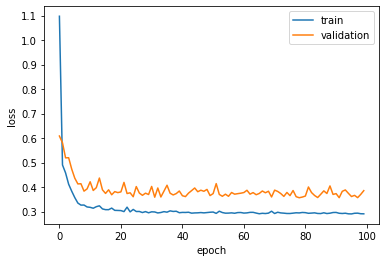

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,1)

axes.plot(train_losses)
axes.plot(valid_losses)
axes.set_xlabel('epoch')
axes.set_ylabel('loss')
axes.legend(['train', 'validation'])


In [7]:
fig.savefig('data/results/model_training.pdf')

In [199]:
next(model.parameters())

Parameter containing:
tensor([0.9999, 1.0000], device='cuda:0', requires_grad=True)

In [212]:
model(graph)

(tensor([0.4641, 0.4625, 0.4641, 0.4637, 0.4633, 0.4637, 0.4636, 0.4663, 0.4635,
         0.4649, 0.4630, 0.4654, 0.4650, 0.4633, 0.4649, 0.4650, 0.4641, 0.4637,
         0.4642, 0.4643, 0.4658, 0.4633, 0.4643, 0.4636, 0.4606, 0.4670, 0.4570,
         0.4575, 0.4560, 0.4585, 0.4545, 0.4570, 0.4656, 0.4635, 0.4636, 0.4636,
         0.4646, 0.4667, 0.4638, 0.4619, 0.4630, 0.4660, 0.4541, 0.4595, 0.4602,
         0.4544, 0.4569, 0.4619, 0.4586, 0.4594, 0.4675, 0.4584, 0.4561, 0.4649,
         0.4567, 0.4561, 0.4522, 0.4680, 0.4661, 0.4640, 0.4629, 0.4608, 0.4561,
         0.4685, 0.4652, 0.4672, 0.4635, 0.4634, 0.4656, 0.4649, 0.4642, 0.4655,
         0.4630, 0.4641, 0.4639, 0.4659, 0.4657, 0.4607, 0.4665, 0.4648],
        device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(1.1692, device='cuda:0', grad_fn=<SumBackward0>))

In [214]:
z_target

tensor([[0.2769, 0.2769, 0.2768, 0.2768, 0.2769, 0.2769, 0.2768, 0.2768],
        [0.3813, 1.0000, 0.3810, 1.0000, 0.3811, 0.3812, 1.0000, 0.3812],
        [0.2769, 0.2769, 0.2769, 0.2769, 0.2769, 0.2768, 0.2769, 0.2768],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2768, 0.2768, 0.2769, 0.2768, 0.2769, 0.2769, 0.2768, 0.2768],
        [1.0000, 1.0000, -0.0000, -0.0000, 1.0000, -0.0000, -0.0000, 1.0000],
        [-0.0000, -0.0000, 1.0000, -0.0000, -0.0000, 1.0000, -0.0000, -0.0000],
        [-0.0000, 1.0000, -0.0000, 1.0000, 1.0000, 1.0000, -0.0000, 1.0000],
        [0.4539, 1.0000, 0.4539, 0.4539, 0.4539, 0.4539, 0.4539, 0.4539],
        [0.4471, 0.4470, 0.4472, 0.4470, 1.0000, 0.4469, 1.0000, 0.4472]],
       device='cuda:0')

In [215]:
power_target

tensor([ 0.1872,  0.2619,  0.1974,  0.0000,  0.2514,  0.6482, 17.7188,  0.3639,
         0.3097,  0.3190], device='cuda:0')

## Linear Model and Observation

In [ ]:
class LinearObservation(object):
    def __init__(self, H_complex, z_sol, z_mask):
        self.obs = 
        
    def extract(self, graph_observation):
        return sel
    

## Data Collection

In [145]:
import numpy as np
import torch
from antenna_selection.beamforming_test import Beamforming
from tqdm import tqdm, trange
# Generate Training Examples 
# save the training examples in pkl
NUM_TRAIN_H = 1000
N, M = 8,3
L = 5

H_complex = np.random.randn(NUM_TRAIN_H, N,M) + 1j*np.random.randn(NUM_TRAIN_H,N,M)

z_sol = []
z_mask = []
for i in trange(NUM_TRAIN_H):
    p_sol = np.random.rand(1)
    p_mask = np.random.rand(1)
    z_sol.append(np.random.binomial(size=N, n=1, p=p_sol))
    z_mask.append(np.random.binomial(size=N, n=1, p=p_mask))
z_sol = np.array(z_sol)
z_mask = np.array(z_mask)

# Solve each problem using cvxpy
sol = {'z': [], 'W': [], 'power': []}
for i in trange(NUM_TRAIN_H):
    bm_solver = Beamforming(H_complex[i,:,:], max_ant=L)
    z, W, power = bm_solver.solve_beamforming(z_sol=z_sol[i,:], z_mask=z_mask[i,:])
    if z is not None:
        sol['z'].append(z)
        sol['W'].append(W)
        sol['power'].append(power)
    else:
        sol['z'].append(np.zeros(N))
        sol['W'].append(np.zeros((N,M)))
        sol['power'].append(np.float64(-1))
        
# sol['z'] = np.array(sol['z'])
# sol['W'] = np.array(sol['W'])
# sol['power'] = np.array(sol['power'])

sol = (np.array(sol['z']), np.array(sol['W']), np.array(sol['power']))

target = []
obs = []
for i in range(NUM_TRAIN_H):
    obs.append(LowerBoundObservation(H_complex[i,:,:], z_sol[i,:], z_mask[i,:]))
    target.append((sol[0][i,::], sol[1][i,::], sol[2][i]))
    
# Save the file in pkl
data = {'params':{'H': H_complex, 'z_sol': z_sol, 'z_mask': z_mask}, 'in':obs, 'out': target}
filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/validset1.pkl'
with open(filepath, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) 


  0%|          | 3/1000 [00:00<03:32,  4.70it/s]

infeasible solution
infeasible solution


  1%|▏         | 13/1000 [00:02<03:02,  5.40it/s]

infeasible solution


  2%|▏         | 23/1000 [00:04<03:21,  4.86it/s]

infeasible solution


  4%|▎         | 37/1000 [00:08<04:30,  3.55it/s]

infeasible solution


  4%|▍         | 39/1000 [00:09<04:32,  3.53it/s]

infeasible solution


  5%|▍         | 48/1000 [00:11<04:33,  3.48it/s]

infeasible solution


  5%|▌         | 53/1000 [00:13<04:15,  3.71it/s]

infeasible solution


  6%|▋         | 64/1000 [00:16<04:02,  3.85it/s]

infeasible solution


  7%|▋         | 67/1000 [00:16<03:27,  4.49it/s]

infeasible solution


  7%|▋         | 74/1000 [00:18<03:33,  4.33it/s]

infeasible solution


  8%|▊         | 85/1000 [00:21<03:13,  4.73it/s]

infeasible solution


  9%|▉         | 90/1000 [00:22<03:06,  4.88it/s]

infeasible solution
infeasible solution


  9%|▉         | 91/1000 [00:22<03:10,  4.77it/s]

infeasible solution


  9%|▉         | 93/1000 [00:22<03:14,  4.68it/s]

infeasible solution


  9%|▉         | 94/1000 [00:23<03:24,  4.43it/s]

infeasible solution


 10%|█         | 104/1000 [00:25<03:33,  4.19it/s]

infeasible solution


 11%|█         | 110/1000 [00:27<04:09,  3.56it/s]

infeasible solution


 12%|█▏        | 115/1000 [00:28<04:11,  3.51it/s]

infeasible solution


 12%|█▏        | 122/1000 [00:30<04:01,  3.64it/s]

infeasible solution


 12%|█▏        | 124/1000 [00:31<03:55,  3.73it/s]

infeasible solution


 13%|█▎        | 131/1000 [00:33<04:28,  3.24it/s]

infeasible solution


 14%|█▎        | 136/1000 [00:34<04:17,  3.35it/s]

infeasible solution


 14%|█▍        | 139/1000 [00:35<03:31,  4.07it/s]

infeasible solution


 15%|█▍        | 148/1000 [00:37<03:06,  4.56it/s]

infeasible solution


 15%|█▌        | 150/1000 [00:38<03:24,  4.16it/s]

infeasible solution


 15%|█▌        | 153/1000 [00:38<03:25,  4.13it/s]

infeasible solution


 17%|█▋        | 166/1000 [00:42<03:06,  4.48it/s]

infeasible solution


 18%|█▊        | 176/1000 [00:44<03:16,  4.19it/s]

infeasible solution


 18%|█▊        | 181/1000 [00:45<02:48,  4.86it/s]

infeasible solution


 26%|██▌       | 259/1000 [01:00<02:24,  5.13it/s]

infeasible solution


 26%|██▌       | 261/1000 [01:00<02:28,  4.98it/s]

infeasible solution


 27%|██▋       | 273/1000 [01:03<02:34,  4.72it/s]

infeasible solution


 29%|██▊       | 287/1000 [01:06<03:07,  3.79it/s]

infeasible solution


 30%|███       | 304/1000 [01:10<02:58,  3.90it/s]

infeasible solution


 31%|███       | 307/1000 [01:11<02:24,  4.80it/s]

infeasible solution
infeasible solution


 32%|███▏      | 318/1000 [01:13<02:16,  4.99it/s]

infeasible solution


 32%|███▏      | 321/1000 [01:14<02:22,  4.77it/s]

infeasible solution


 32%|███▏      | 323/1000 [01:14<02:13,  5.08it/s]

infeasible solution


 33%|███▎      | 326/1000 [01:15<02:02,  5.52it/s]

infeasible solution
infeasible solution


 33%|███▎      | 329/1000 [01:16<02:29,  4.50it/s]

infeasible solution


 34%|███▍      | 342/1000 [01:18<02:20,  4.68it/s]

infeasible solution


 35%|███▍      | 347/1000 [01:19<02:08,  5.08it/s]

infeasible solution


 37%|███▋      | 372/1000 [01:24<02:05,  5.01it/s]

infeasible solution


 38%|███▊      | 376/1000 [01:25<01:56,  5.38it/s]

infeasible solution


 38%|███▊      | 382/1000 [01:26<01:42,  6.05it/s]

infeasible solution


 39%|███▊      | 386/1000 [01:27<01:41,  6.05it/s]

infeasible solution


 39%|███▉      | 394/1000 [01:28<01:51,  5.45it/s]

infeasible solution


 40%|███▉      | 398/1000 [01:29<01:36,  6.22it/s]

infeasible solution


 44%|████▎     | 435/1000 [01:36<01:09,  8.08it/s]

infeasible solution


 44%|████▎     | 437/1000 [01:37<01:05,  8.64it/s]

infeasible solution


 44%|████▍     | 441/1000 [01:37<01:03,  8.78it/s]

infeasible solution


 44%|████▍     | 444/1000 [01:41<08:25,  1.10it/s]

infeasible solution


 45%|████▌     | 453/1000 [01:45<02:18,  3.95it/s]

infeasible solution


 48%|████▊     | 478/1000 [01:50<01:44,  4.98it/s]

infeasible solution


 48%|████▊     | 479/1000 [01:50<02:00,  4.33it/s]

infeasible solution


 48%|████▊     | 484/1000 [01:51<01:55,  4.45it/s]

infeasible solution


 49%|████▉     | 490/1000 [01:53<01:39,  5.11it/s]

infeasible solution
infeasible solution


 50%|████▉     | 499/1000 [01:54<01:43,  4.83it/s]

infeasible solution


 50%|█████     | 501/1000 [01:55<01:44,  4.77it/s]

infeasible solution


 50%|█████     | 502/1000 [01:55<02:02,  4.07it/s]

infeasible solution


 50%|█████     | 504/1000 [01:56<01:59,  4.14it/s]

infeasible solution


 51%|█████     | 510/1000 [01:57<02:24,  3.39it/s]

infeasible solution


 54%|█████▍    | 541/1000 [02:07<02:12,  3.48it/s]

infeasible solution


 54%|█████▍    | 542/1000 [02:07<02:10,  3.52it/s]

infeasible solution


 54%|█████▍    | 544/1000 [02:08<02:19,  3.27it/s]

infeasible solution


 55%|█████▌    | 554/1000 [02:11<02:10,  3.43it/s]

infeasible solution


 56%|█████▌    | 556/1000 [02:11<01:54,  3.87it/s]

infeasible solution


 56%|█████▌    | 557/1000 [02:11<01:56,  3.81it/s]

infeasible solution


 57%|█████▋    | 568/1000 [02:14<01:40,  4.31it/s]

infeasible solution


 57%|█████▋    | 571/1000 [02:15<01:29,  4.77it/s]

infeasible solution


 58%|█████▊    | 578/1000 [02:16<01:41,  4.15it/s]

infeasible solution


 58%|█████▊    | 580/1000 [02:17<01:32,  4.55it/s]

infeasible solution


 58%|█████▊    | 582/1000 [02:17<01:38,  4.26it/s]

infeasible solution


 62%|██████▏   | 615/1000 [02:26<01:29,  4.31it/s]

infeasible solution


 62%|██████▎   | 625/1000 [02:28<01:37,  3.87it/s]

infeasible solution


 63%|██████▎   | 628/1000 [02:29<01:33,  3.98it/s]

infeasible solution


 63%|██████▎   | 633/1000 [02:30<01:15,  4.85it/s]

infeasible solution


 64%|██████▎   | 636/1000 [02:31<01:29,  4.06it/s]

infeasible solution


 65%|██████▌   | 652/1000 [02:34<01:06,  5.23it/s]

infeasible solution


 65%|██████▌   | 654/1000 [02:34<01:16,  4.55it/s]

infeasible solution


 66%|██████▌   | 659/1000 [02:36<01:32,  3.70it/s]

infeasible solution


 71%|███████   | 708/1000 [02:50<01:10,  4.14it/s]

infeasible solution


 72%|███████▏  | 722/1000 [02:53<01:03,  4.38it/s]

infeasible solution


 74%|███████▍  | 743/1000 [02:57<00:47,  5.36it/s]

infeasible solution


 76%|███████▌  | 761/1000 [03:00<00:44,  5.41it/s]

infeasible solution


 77%|███████▋  | 770/1000 [03:02<00:40,  5.65it/s]

infeasible solution


 79%|███████▉  | 791/1000 [03:09<00:53,  3.87it/s]

infeasible solution


 79%|███████▉  | 794/1000 [03:10<00:45,  4.50it/s]

infeasible solution


 80%|███████▉  | 798/1000 [03:11<00:36,  5.57it/s]

infeasible solution


 80%|████████  | 804/1000 [03:12<00:41,  4.69it/s]

infeasible solution


 81%|████████  | 806/1000 [03:12<00:44,  4.34it/s]

infeasible solution


 82%|████████▏ | 817/1000 [03:15<00:35,  5.20it/s]

infeasible solution


 83%|████████▎ | 829/1000 [03:17<00:42,  4.01it/s]

infeasible solution


 83%|████████▎ | 834/1000 [03:19<00:40,  4.10it/s]

infeasible solution


 84%|████████▍ | 840/1000 [03:20<00:46,  3.45it/s]

infeasible solution


 84%|████████▍ | 845/1000 [03:22<00:43,  3.59it/s]

infeasible solution


 85%|████████▍ | 849/1000 [03:23<00:43,  3.48it/s]

infeasible solution


 87%|████████▋ | 866/1000 [03:27<00:29,  4.50it/s]

infeasible solution


 88%|████████▊ | 877/1000 [03:29<00:22,  5.43it/s]

infeasible solution


 89%|████████▉ | 889/1000 [03:32<00:25,  4.43it/s]

infeasible solution


 89%|████████▉ | 892/1000 [03:33<00:25,  4.26it/s]

infeasible solution


 90%|█████████ | 902/1000 [03:36<00:27,  3.51it/s]

infeasible solution


 90%|█████████ | 904/1000 [03:36<00:26,  3.62it/s]

infeasible solution


 91%|█████████ | 909/1000 [03:38<00:25,  3.60it/s]

infeasible solution


 92%|█████████▏| 917/1000 [03:40<00:23,  3.57it/s]

infeasible solution


 93%|█████████▎| 929/1000 [03:43<00:19,  3.57it/s]

infeasible solution


 94%|█████████▍| 942/1000 [03:46<00:12,  4.71it/s]

infeasible solution


 94%|█████████▍| 944/1000 [03:47<00:12,  4.39it/s]

infeasible solution


 95%|█████████▌| 951/1000 [03:48<00:10,  4.86it/s]

infeasible solution


 96%|█████████▌| 961/1000 [03:51<00:07,  4.99it/s]

infeasible solution


 96%|█████████▋| 965/1000 [03:51<00:07,  4.99it/s]

infeasible solution


 98%|█████████▊| 981/1000 [03:55<00:03,  5.20it/s]

infeasible solution


100%|█████████▉| 999/1000 [03:58<00:00,  5.88it/s]

infeasible solution


100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


In [114]:
type(sol)

dict

In [141]:

# sol = (np.array(sol['z']), np.array(sol['W']), np.array(sol['power']))

target = []
obs = []
for i in range(NUM_TRAIN_H):
    obs.append(LowerBoundObservation(H_complex[i,:,:], z_sol[i,:], z_mask[i,:]))
    target.append((sol[0][i,::], sol[1][i,::], sol[2][i]))
    
# Save the file in pkl
data = {'params':{'H': H_complex, 'z_sol': z_sol, 'z_mask': z_mask}, 'in':obs, 'out': target}
filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/validset1.pkl'
with open(filepath, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) 


IndexError: index 18 is out of bounds for axis 0 with size 18

## Data Pruning

In [53]:
import pickle
filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/trainset1.pkl'
with open(filepath, 'rb') as handle:
    data = pickle.load(handle)
    
# check data
# for i in range(100):
#     if data['out'][i][2] > 2:
#         print(data['in'][i].antenna_features, data['out'][i][2])

new_data = {'in':[], 'out':[]}
for i in range(len(data['in'])):
    if data['out'][i][2] > 0 and data['out'][i][2] < 2 :
        new_data['in'].append(data['in'][i])
        new_data['out'].append(data['out'][i])
        
print('data size', len(new_data['in']))

# save data
filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/trainset1_pruned.pkl'
with open(filepath, 'wb') as handle:
    pickle.dump(new_data, handle, protocol=pickle.HIGHEST_PROTOCOL) 


data size 8368


## Observation to Linear Observation

In [6]:
import pickle
filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/validset1.pkl'
with open(filepath, 'rb') as handle:
    data = pickle.load(handle)
    
# check data
# for i in range(100):
#     if data['out'][i][2] > 2:
#         print(data['in'][i].antenna_features, data['out'][i][2])

new_data = {'in':[], 'out':[]}
for i in range(len(data['in'])):
    if data['out'][i][2] > 0 and data['out'][i][2] < 2 :
        linear_obs = LinearLowerBoundObservation(data['params']['H'][i], data['params']['z_sol'][i], data['params']['z_mask'][i])
        new_data['in'].append(linear_obs)
        new_data['out'].append(data['out'][i])

print('data size', len(new_data['in']))

# save data
filepath = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/data/bound_approximation/validset1_linear_pruned.pkl'
with open(filepath, 'wb') as handle:
    pickle.dump(new_data, handle, protocol=pickle.HIGHEST_PROTOCOL) 


data size 834


In [ ]:
data

In [52]:
len(data['in'])

10000

In [48]:
np.abs(data['params']['H'][0]).reshape(-1)

array([1.11564795, 1.43990595, 1.94171292, 0.73024635, 1.78498364,
       1.86398361, 1.21960891, 2.0601011 , 1.75103837, 2.62009032,
       1.94508909, 1.46316805, 0.81350504, 1.22580305, 1.57157851,
       0.66226483, 0.26367738, 1.3295895 , 1.04369569, 0.96843053,
       0.24188002, 1.96912241, 1.17307799, 0.84313454])

In [19]:
type(data['out'])

list

In [15]:
data['out'][2]

(array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]]),
 -1.0)

In [159]:
len(data['out'][0])

3

In [126]:
handle.close()

In [ ]:
data

In [120]:
sol[3].shape

IndexError: tuple index out of range